# FINAL PROJECT

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
from tqdm import tqdm
from xgboost import XGBClassifier
from graphviz import Source

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, auc, roc_curve, classification_report

warnings.filterwarnings('ignore')

# read the dataset
df = pd.read_csv("promotions.csv")

### Exploring the Data

###### exhibit the number of rows and the number of columns in the data

In [2]:
row ,columns = df.shape
print(f"rows: {row}\ncolumns: {columns}")

rows: 54808
columns: 14


In [3]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


##### Distribution of labels

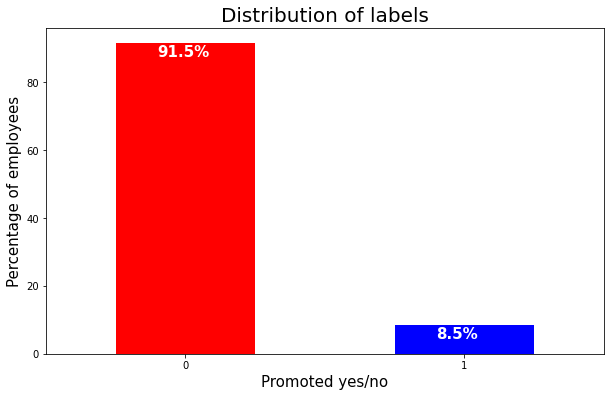

In [4]:
ax =(df['is_promoted'].value_counts()*100/len(df)).plot(kind='bar',stacked = True, rot=0,color= ("red","blue"), figsize=(10,6))
plt.xlabel('Promoted yes/no',size = 15)
plt.ylabel('Percentage of employees',size = 15)
plt.title('Distribution of labels',size = 20)
lst = []
for i in ax.patches:
    lst.append(i.get_width())
lst = sum(lst)
for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/lst), 1))+'%', color='white',weight = 'bold',size = 15)

###### visualizing with 3 graphs the distribution of the target label by each numerical feature 

In [5]:
def show_dist_graphs(col):
    fig, axes = plt.subplots(ncols=3,figsize=(15,5))
    fig.tight_layout(pad=0.4, w_pad=2.346, h_pad=1.0)
    df.groupby([col]).sum()['is_promoted'].plot(ax=axes[0])
    df.groupby([col]).mean()['is_promoted'].plot(ax=axes[1])
    df.groupby([col]).count()['employee_id'].plot(ax=axes[2])
    axes[0].title.set_text('Distribution of promoted by '+col+ ' - sum')
    axes[1].title.set_text('Distribution of employees by '+col+ ' - mean')
    axes[2].title.set_text('Distribution of employees by '+col)
    axes[0].set_ylabel('Sum of is_promoted',fontsize = 10)
    axes[1].set_ylabel('Mean of is_promoted',fontsize = 10)
    axes[2].set_ylabel('count of employees',fontsize = 10)

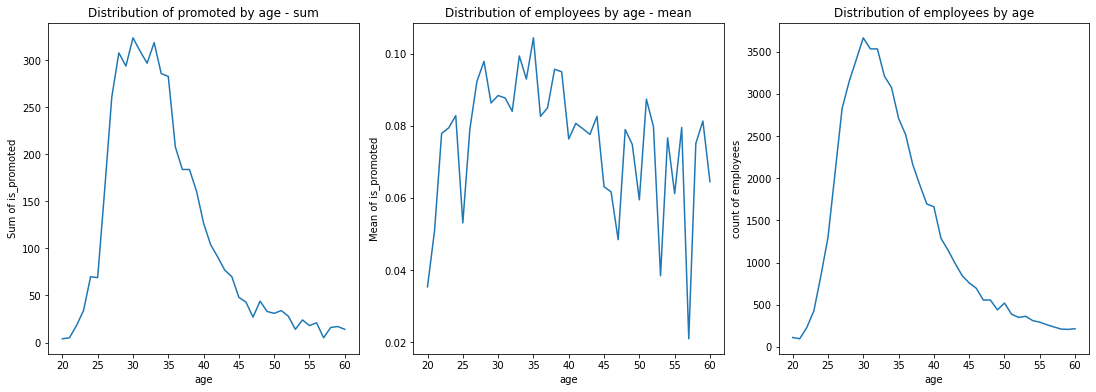

In [6]:
show_dist_graphs('age')

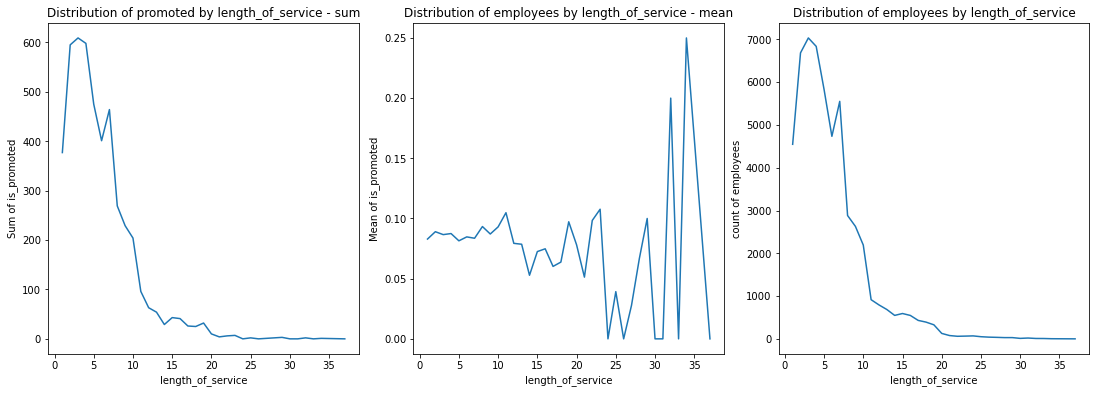

In [7]:
show_dist_graphs('length_of_service')

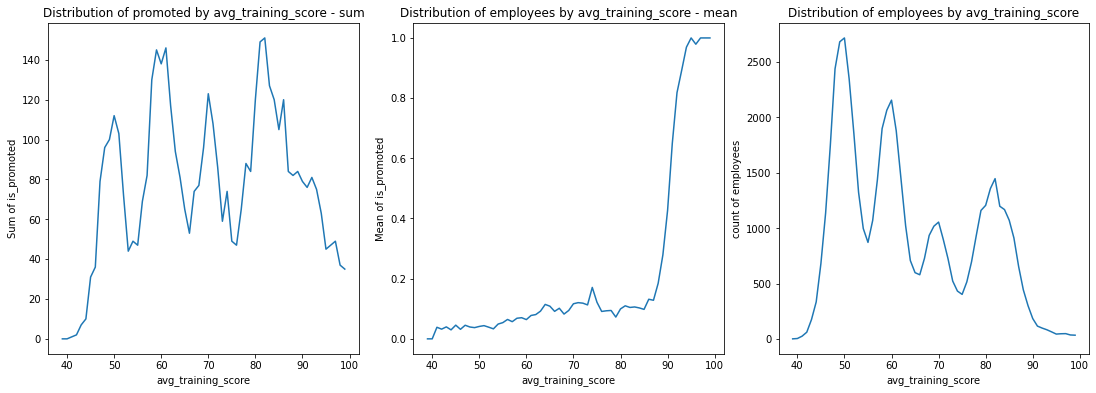

In [8]:
show_dist_graphs('avg_training_score')

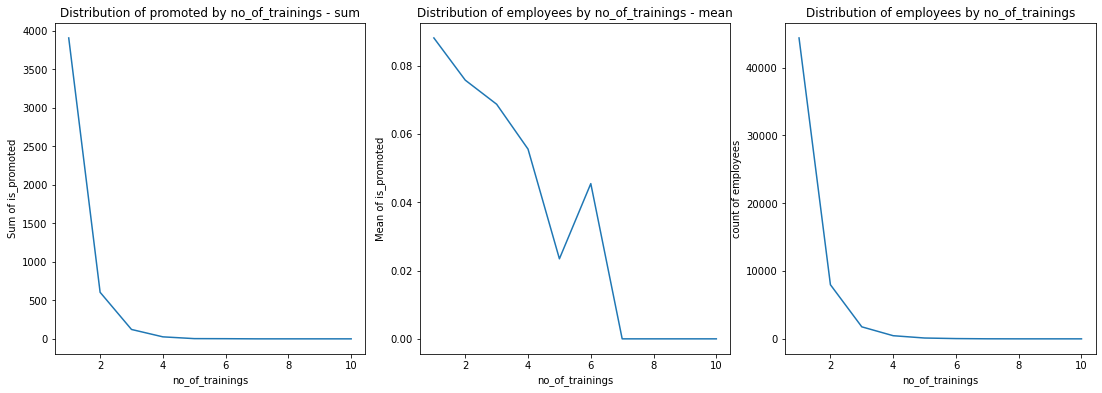

In [9]:
show_dist_graphs('no_of_trainings')

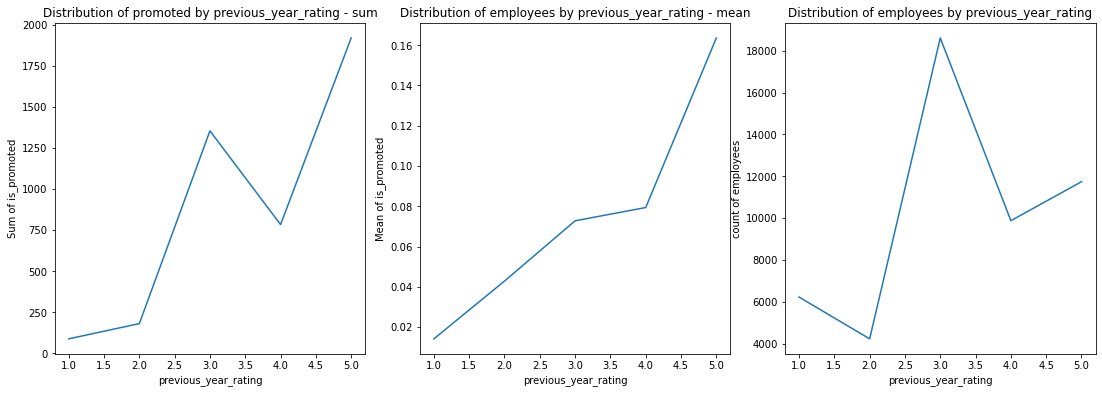

In [10]:
show_dist_graphs('previous_year_rating')

##### With pie chart, visualizing  the distribution of employees who met their KPI 

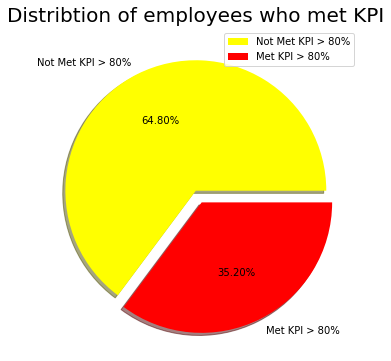

In [11]:
# plotting a pie chart
metKPI = df['KPIs_met >80%'].sum()
size = [row - metKPI, metKPI]
labels = "Not Met KPI > 80%", "Met KPI > 80%"
colors = ['yellow', 'red']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (6, 6)
plt.pie(size, labels = labels, colors = colors, explode = explode, shadow = True, autopct = "%.2f%%")
plt.title('Distribtion of employees who met KPI', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

###### With histogram, visualizing the distribution of the employees by their region

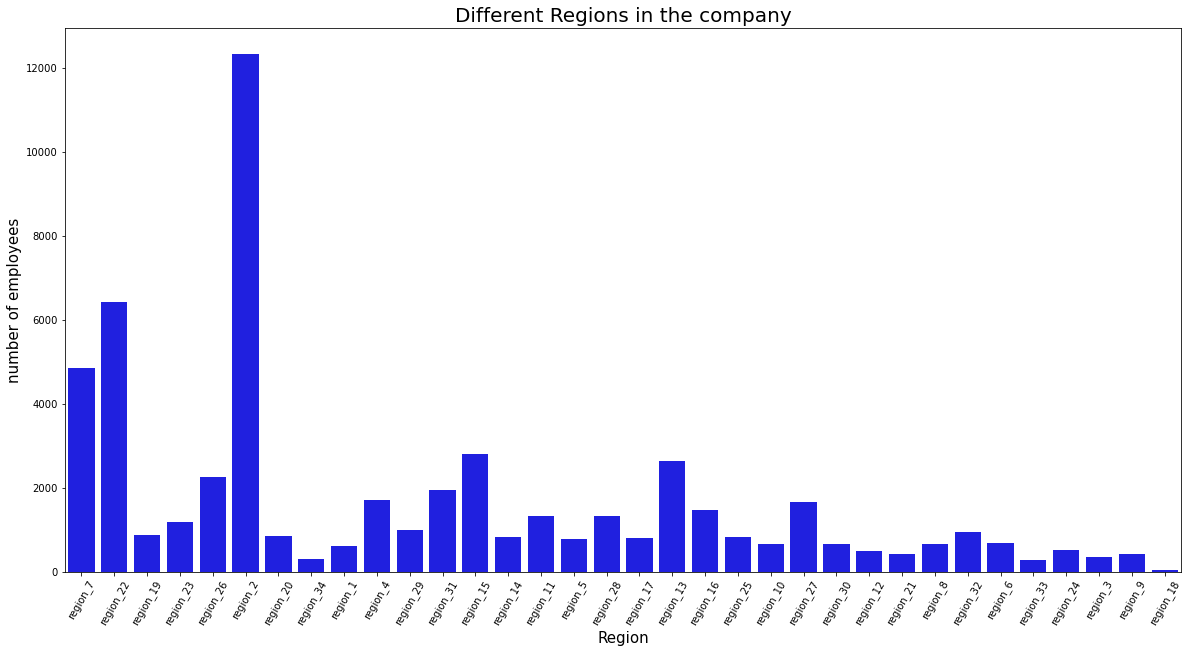

In [12]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(df['region'], color = 'blue')
plt.title('Different Regions in the company', fontsize = 20)
plt.xticks(rotation = 60)
plt.xlabel('Region', fontsize = 15)
plt.ylabel('number of employees', fontsize = 15)
plt.show()

##### With plot bar, visualizing the distribution of employees who won awards

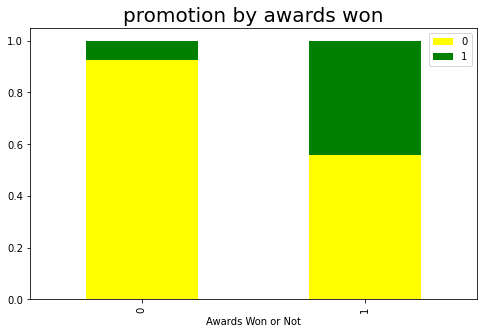

In [13]:
#  promotion by awards won

data = pd.crosstab(df['awards_won?'], df['is_promoted'])
data.div(data.sum(1).astype('float'), axis = 0).plot(kind = 'bar', stacked = True, figsize = (8, 5), color = ['yellow', 'green'])

plt.title('promotion by awards won', fontsize = 20)
plt.xlabel('Awards Won or Not', fontsize = 10)
plt.legend()
plt.show()

### Feature Engineering

###### At first, we checked if there are missing values in the data 

In [14]:
# check and fill missing values
df.isna().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

###### We found that there were  a lot of missing values in 2 columns: previous_year_rating, education, and because  there were thousands of missing values and our data is already imbalance we can just remove those obs, so we filled the missing values with the mode and the median.

In [15]:
df['education'].fillna(df.education.mode()[0],inplace=True)
df['previous_year_rating'].fillna(df.previous_year_rating.median(),inplace=True)

In [16]:
df.isna().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

##### Now we checked the distribution by quarters of age for binning the feature 

In [17]:
df.age.describe()

count    54808.000000
mean        34.803915
std          7.660169
min         20.000000
25%         29.000000
50%         33.000000
75%         39.000000
max         60.000000
Name: age, dtype: float64

##### Here we used some feature engineering techniques. Some worked well and some didn't. We put those which didn't work as we expected inside comments

In [18]:
## encoding "region" columns
labelEncoder1 = LabelEncoder()
labelEncoder1.fit(df['region'])
df['region'] = labelEncoder1.transform(df['region'])

# add dummy variables
dummies = df[['gender','education','recruitment_channel','department']]
dummies = pd.get_dummies(dummies)
data = pd.concat([df.drop(['employee_id','gender','education','recruitment_channel','department'],axis=1),dummies],axis=1)


data.loc[data.age<=29,'age'] = 1
data.loc[(data.age>29) & (data.age<=33),'age'] = 2
data.loc[(data.age>33) & (data.age<=39),'age'] = 3
data.loc[data.age>39,'age'] = 4

data['train_score>90'] = 0
data.loc[data['avg_training_score']>=90,'train_score>90'] = 1

# adding polynomial features ----> didnt work well
'''
data['length_of_service_sq'] = data.length_of_service**2
data['age_sq'] = data.age**2
data['ln_train_score'] = np.log(data['avg_training_score'])
'''
# adding all possible interaction features - more then 1800 feature ---> didnt work well
'''
#from itertools import combinations
#interactions = {i[0]+'_'+i[1]:i for i in list(combinations(list(data.columns), 2)) if 'is_promoted' not in i}
#for i in interactions.items():
#    data[i[0]] = data[i[1][0]]*data[i[1][1]]
'''  
#### we tried to transform no_of_trainings to boolean - didnt work well
'''
#data['no_of_trainings<2'] = 0
#data.loc[data['no_of_trainings']>=2,'no_of_trainings<2'] = 1
'''

w,h = data.shape
print(f"rows: {w}\ncolumns: {h}")

rows: 54808
columns: 27


# FEATURE SELECTION

##### Here we divided the data into 2 parts X which gets all the features without the target lable and y which gets only the target label

In [19]:
X = data.drop('is_promoted',axis=1)
y = data['is_promoted']

In [20]:
## we tried to scaled te data for all the model but except from the KNN all the scores of the other models(the good ones) went down  
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

In [21]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
#1 feature selection
def foo1(X,y,method,j):
    rfe = RFE(estimator=method, n_features_to_select=j)
    # fit RFE
    Xnew = rfe.fit_transform(X, y)
    #print([X.columns[i] for i in range(len(rfe.support_)) if rfe.support_[i]==True])
    Xnewnewnew = pd.DataFrame(Xnew, index=X.index, columns=[X.columns[i] for i in range(len(rfe.support_)) if rfe.support_[i]==True])
    # summarize all features
    #for i in range(X.shape[1]):
    #    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))
    return Xnewnewnew, rfe.ranking_

#2 create variables with features
def foo2(data,y,size):
    return train_test_split(data, y, test_size=size,random_state=0)

#3 take the features and put in model
def foo3(model,X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    f1 = f1_score(y_test,y_test_pred)
    precision = precision_score(y_test,y_test_pred)
    recall = recall_score(y_test,y_test_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    
    
    return y_train_pred,y_test_pred, f1 ,precision, recall,auc(fpr,tpr), clf


###### Here we employed a feature selection technique called RFE on XGBClassifier model. We chose to perform the  RFE on XGBClassifier, because this model gave us the best results(We tried them all). 
###### Moreover, from now on because our data is very imbalanced we will use the f1 score, AUC, precision, and recall as metrics to evaluate the models

In [22]:

r = range(1, X.shape[1]+1)
#c = range(0,1)
bestf1 = 0
best_i =0
for i in tqdm(r):
    ## we use XGBClassifier for the selction because this it gives the best result
    t1 = foo1(X,y,XGBClassifier(n_estimators=100, max_depth=3,scale_pos_weight=2,verbosity=0),16)
    X_train, X_test, y_train, y_test = foo2(t1[0],y,0.3)
    y_train_pred,y_test_pred, f1 ,precision, recall,auc1, clf = foo3(XGBClassifier(n_estimators=100, 
                                                                                   max_depth=3,
                                                                                   scale_pos_weight=2,
                                                                                  verbosity=0),
                                                                             X_train, X_test, y_train, y_test)
    if bestf1<f1:
        best = (X_train, X_test, y_train, y_test,y_train_pred,y_test_pred, f1 ,precision, recall,auc1, clf,t1[1],t1[0])
        bestf1 = f1
        best_i = i
    


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [01:36<00:00,  3.70s/it]


###### Here we split the data to train and test with the selected features

In [23]:
X_train, X_test, y_train, y_test = best[0:4]

### Classification baseline - benchmark

#### Here we employed  the Classification baseline model which we will use as benchmark. The model predicts the mode value of the target label for each obs.

f1 score: 0.0 Precision: 0.0


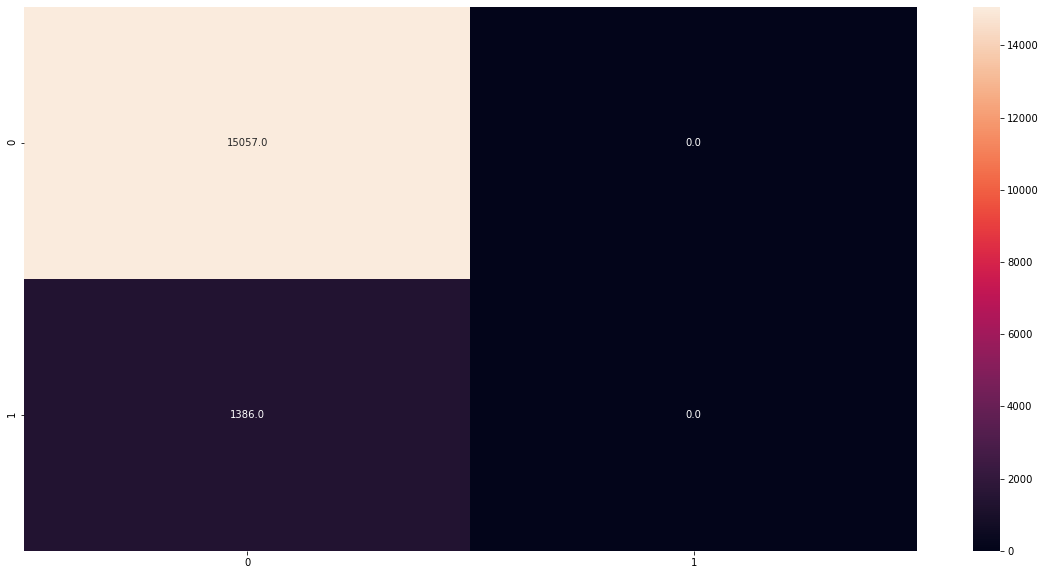

In [24]:
def get_benchmark_predictions(x, benchmark_value):
    # returns a numpy array on the same length as x with all values equal to benchmark_value
    return np.ones(len(x))*benchmark_value

def confu(y_test_old,y_test_pred):
    cm = confusion_matrix(y_test_old,y_test_pred)
    sns.heatmap(cm,annot=True,fmt=".1f")

def get_benchmark_performences(value, X_train, X_test, y_train, y_test):  
    benchmark_value = value
    y_train_pred = get_benchmark_predictions(X_train, benchmark_value)
    y_test_pred = get_benchmark_predictions(X_test, benchmark_value)
    f1 = f1_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    return y_test_pred , f1, prec

y_test_pred_0 , f1_0, prec_0 = get_benchmark_performences(0,X_train, X_test, y_train, y_test)
print("f1 score:", f1_0 , "Precision:", prec_0)
confu(y_test,y_test_pred_0)

##### After we tried the regular baseline we saw that the precision and recall are equal to 0, So we tried to change the baseline that the benchmark value will be 1. Because the precision is more important metrix in our case we think it is a good baseline and we will want to improve this low precision in our models

f1 score: 0.15547703180212014 Precision: 0.0842911877394636


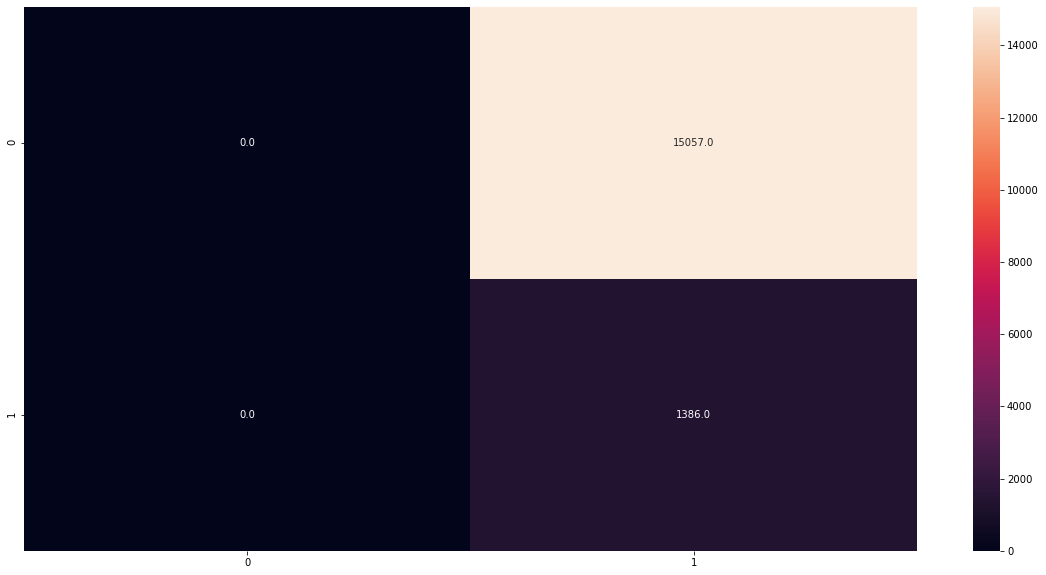

In [25]:
y_test_pred_1 , f1_1, prec_1 = get_benchmark_performences(1,X_train, X_test, y_train, y_test)
print("f1 score:", f1_1 , "Precision:", prec_1)
confu(y_test,y_test_pred_1)

##### Here, we used 8 kinds of models using the train and test data as we used before. We tried each type 3 times with different depth or K as written in the question 

### KNN Model


In [26]:
models = {}

for i in range(2,5):
    y_train_pred_knn,y_test_pred_knn, f1_knn, precision_knn, recall_knn, t_auc_knn, clf_knn = foo3(KNeighborsClassifier(n_neighbors=i),
                                                                                             X_train, X_test, y_train, y_test)
    models[f'knn_{i}'] = y_train_pred_knn,y_test_pred_knn, f1_knn, precision_knn, recall_knn, t_auc_knn, clf_knn
    print('model:', f'knn_{i}')
    print("AUC:",t_auc_knn,"f1 score:",f1_knn)
    print("precision:",precision_knn,"recall:",recall_knn)

model: knn_2
AUC: 0.6469219994324596 f1 score: 0.44031830238726793
precision: 0.8316633266533067 recall: 0.2994227994227994
model: knn_3
AUC: 0.6668719472066753 f1 score: 0.4507819687212512
precision: 0.6218274111675127 recall: 0.35353535353535354
model: knn_4
AUC: 0.6428918594190561 f1 score: 0.4324034334763949
precision: 0.8430962343096234 recall: 0.2907647907647908


### KNN model with scaled values

In [27]:
for i in range(2,5):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train_pred_knn_scaled,y_test_pred_knn_scaled, f1_knn_scaled,precision_knn_scaled, recall_knn_scaled,t_auc_knn_scaled, clf_knn_scaled = foo3(KNeighborsClassifier(n_neighbors=i),
                                                                                                                                                  X_train_scaled, X_test_scaled, y_train, y_test)
    models[f'scaled_knn_{i}'] = y_train_pred_knn_scaled,y_test_pred_knn_scaled, f1_knn_scaled,precision_knn_scaled, recall_knn_scaled,t_auc_knn_scaled, clf_knn_scaled
    
    print('model:', f'scaled_knn_{i}')
    print("AUC:",t_auc_knn_scaled,"f1 score:",f1_knn_scaled)
    print("precision:",precision_knn_scaled,"recall:",recall_knn_scaled)

model: scaled_knn_2
AUC: 0.6475016150748368 f1 score: 0.437597911227154
precision: 0.7920604914933838 recall: 0.3023088023088023
model: scaled_knn_3
AUC: 0.6671376043760981 f1 score: 0.45244690674053556
precision: 0.6282051282051282 recall: 0.35353535353535354
model: scaled_knn_4
AUC: 0.640494907231309 f1 score: 0.42573726541554957
precision: 0.8288100208768268 recall: 0.28643578643578643



### Tree Model

In [28]:
for i in range(2,5):
    y_train_pred_tree,y_test_pred_tree, f1_tree ,precision_tree, recall_tree,t_auc_tree, clf_tree = foo3(DecisionTreeClassifier(max_depth=i,random_state=0),
                                                                                              X_train, X_test, y_train, y_test)
    models[f'tree_{i}'] = y_train_pred_tree,y_test_pred_tree, f1_tree ,precision_tree, recall_tree,t_auc_tree, clf_tree
    print('model:', f'tree_{i}')
    print("AUC:",t_auc_tree,"f1 score:",f1_tree)
    print("precision:",precision_tree,"recall:",recall_tree)

model: tree_2
AUC: 0.5547917911934649 f1 score: 0.1970569417786308
precision: 0.8700564971751412 recall: 0.1111111111111111
model: tree_3
AUC: 0.5501443001443002 f1 score: 0.1822950819672131
precision: 1.0 recall: 0.10028860028860029
model: tree_4
AUC: 0.5824322121393252 f1 score: 0.28019323671497587
precision: 0.8592592592592593 recall: 0.1673881673881674


### Random Forest Model

In [29]:
for i in range(2,5):
    y_train_pred_rf,y_test_pred_rf, f1_rf ,precision_rf, recall_rf,t_auc_rf, clf_rf  = foo3(RandomForestClassifier(n_estimators=100, max_depth=i),
                                                                                        X_train, X_test, y_train, y_test)
    models[f'random_forest_{i}'] = y_train_pred_rf,y_test_pred_rf, f1_rf ,precision_rf, recall_rf,t_auc_rf, clf_rf
    
    print('model:', f'random_forest_{i}')
    print("AUC:",t_auc_rf,"f1 score:",f1_rf)
    print("precision:",precision_rf,"recall:",recall_rf)

model: random_forest_2
AUC: 0.5075757575757576 f1 score: 0.02985074626865672
precision: 1.0 recall: 0.015151515151515152
model: random_forest_3
AUC: 0.5432236289976876 f1 score: 0.15915119363395228
precision: 0.9836065573770492 recall: 0.08658008658008658
model: random_forest_4
AUC: 0.5564717709069172 f1 score: 0.20284237726098192
precision: 0.9691358024691358 recall: 0.11327561327561328


###  Ada Boost Model

In [30]:
for i in range(2,5):
    lf = DecisionTreeClassifier(max_depth=i)
    y_train_pred_ada,y_test_pred_ada, f1_ada, precision_ada, recall_ada, t_auc_ada, clf_ada = foo3(AdaBoostClassifier(lf,n_estimators=100, random_state=0),
                                                                                               X_train, X_test, y_train, y_test)
    models[f'ada_{i}'] = y_train_pred_ada,y_test_pred_ada, f1_ada, precision_ada, recall_ada, t_auc_ada, clf_ada
    
    print('model:', f'ada_{i}')
    print("AUC:",t_auc_ada,"f1 score:",f1_ada)
    print("precision:",precision_ada,"recall:",recall_ada)

model: ada_2
AUC: 0.6729805526876657 f1 score: 0.5065547981122182
precision: 0.927063339731286 recall: 0.3484848484848485
model: ada_3
AUC: 0.6819283691668628 f1 score: 0.5231243576567318
precision: 0.9089285714285714 recall: 0.36724386724386726
model: ada_4
AUC: 0.6833155222276561 f1 score: 0.5151665837891596
precision: 0.8288 recall: 0.37373737373737376


### XGBoost

In [31]:
for i in range(2,5):
    y_train_pred_xgb,y_test_pred_xgb, f1_xgb ,precision_xgb, recall_xgb,t_auc_xgb, clf_xgb  = foo3(XGBClassifier(n_estimators=100, max_depth=i,scale_pos_weight=2),
                                                                                         X_train, X_test, y_train, y_test)
    models[f'xgb_{i}'] = y_train_pred_xgb,y_test_pred_xgb, f1_xgb ,precision_xgb, recall_xgb,t_auc_xgb, clf_xgb
    print('model:', f'xgb_{i}')
    print("AUC:",t_auc_xgb,"f1 score:",f1_xgb)
    print("precision:",precision_xgb,"recall:",recall_xgb)

model: xgb_2
AUC: 0.6765125855084014 f1 score: 0.5095213587236233
precision: 0.8886894075403949 recall: 0.35714285714285715
model: xgb_3
AUC: 0.6888022484256795 f1 score: 0.531
precision: 0.8648208469055375 recall: 0.38311688311688313
model: xgb_4
AUC: 0.6893199780229068 f1 score: 0.5287128712871287
precision: 0.8422712933753943 recall: 0.3852813852813853


### CatBoost

In [32]:
for i in range(2,5):
    y_train_pred_catboost,y_test_pred_catboost, f1_catboost ,precision_catboost, recall_catboost,t_auc_catboost, clf_catboost  = foo3(CatBoostClassifier(iterations=100, learning_rate=1, depth=i,verbose = 0),
                                                                                                                                  X_train, X_test, y_train, y_test)
    models[f'cat_{i}'] = y_train_pred_catboost,y_test_pred_catboost, f1_catboost ,precision_catboost, recall_catboost,t_auc_catboost, clf_catboost
    print('model:', f'cat_{i}')
    print("AUC:",t_auc_catboost,"f1 score:",f1_catboost)
    print("precision:",precision_catboost,"recall:",recall_catboost)

model: cat_2
AUC: 0.6766212634413471 f1 score: 0.5146137787056367
precision: 0.930188679245283 recall: 0.3556998556998557
model: cat_3
AUC: 0.6792793445513111 f1 score: 0.5211047420531526
precision: 0.9380863039399625 recall: 0.36075036075036077
model: cat_4
AUC: 0.6817713899303857 f1 score: 0.5262065386611312
precision: 0.9371534195933456 recall: 0.3658008658008658


### LightGBM

In [33]:
for i in range(2,5):
    y_train_pred_light,y_test_pred_light, f1_light ,precision_light, recall_light,t_auc_light, clf_light = foo3(LGBMClassifier(max_depth=i),
                                                                                                    X_train, X_test, y_train, y_test)
    models[f'light_{i}'] = y_train_pred_light,y_test_pred_light, f1_light ,precision_light, recall_light,t_auc_light, clf_light
    print('model:', f'light_{i}')
    print("AUC:",t_auc_light,"f1 score:",f1_light)
    print("precision:",precision_light,"recall:",recall_light)

model: light_2
AUC: 0.6269795987369209 f1 score: 0.4034285714285714
precision: 0.9697802197802198 recall: 0.2546897546897547
model: light_3
AUC: 0.6588871379666359 f1 score: 0.47913279132791325
precision: 0.9629629629629629 recall: 0.3189033189033189
model: light_4
AUC: 0.6726288588213275 f1 score: 0.5100956429330499
precision: 0.967741935483871 recall: 0.3463203463203463


## Algorithms introspection 

##### As written in the question- we presented the decision trees and the feature importance of the random forest

### decision tree 

#### The decision tree we got for max depth 2:

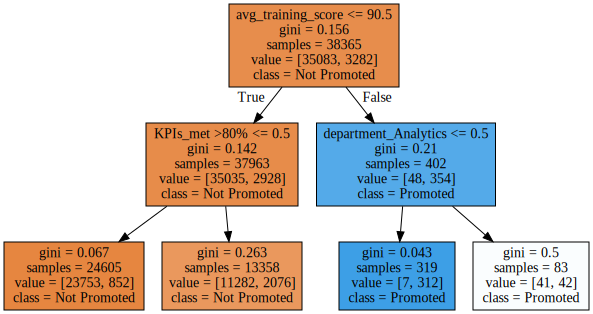

In [38]:
def plot_tree(tree, features, labels,savename):
    #dotfile = open("dtree2.dot", 'w')
    graph = Source(export_graphviz(tree, feature_names=features, class_names=labels, filled = True,out_file = None))
    graph.format= 'png'
    graph.render(savename,view=True)
    display(SVG(graph.pipe(format='svg')))

plot_tree(models['tree_2'][-1], features=X_train.columns, labels=['Not Promoted', 'Promoted'],savename='tree1')





#### The decision tree we got for max depth 3:

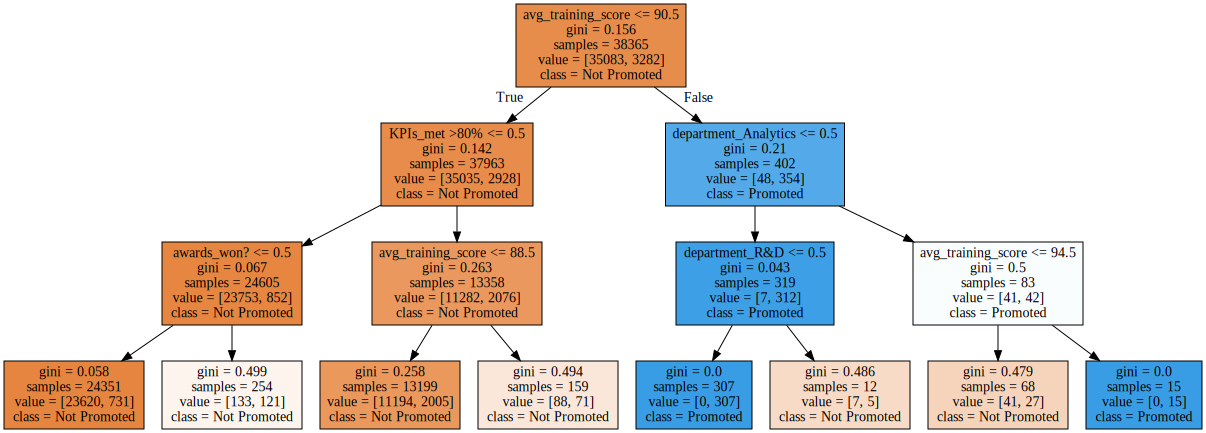

In [39]:
plot_tree(models['tree_3'][-1], features=X_train.columns, labels=['Not Promoted', 'Promoted'],savename='tree2')



#### The decision tree we got for max depth 4:

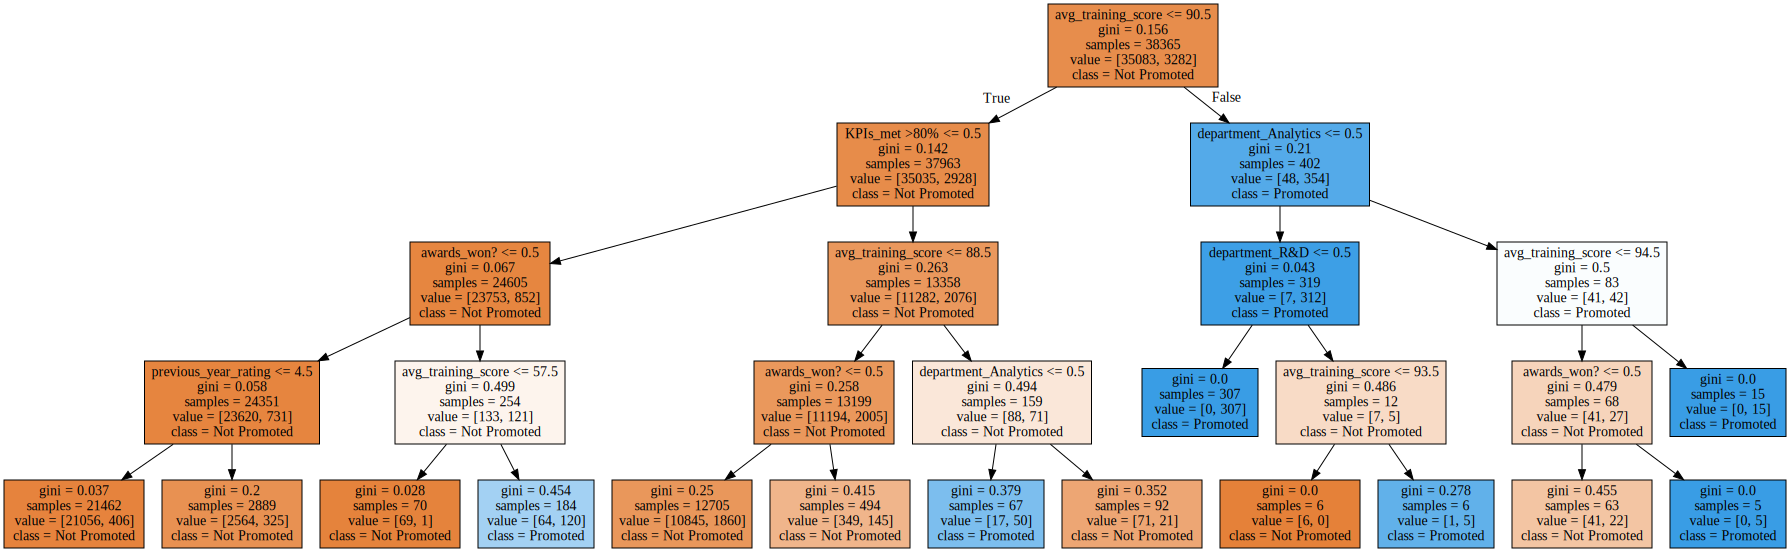

In [40]:
plot_tree(models['tree_4'][-1], features=X_train.columns, labels=['Not Promoted', 'Promoted'],savename='tree3')



### Random Forest - Feature Importance

###### Feature importance for random forest with max depth 2

In [41]:
feature_importances = models['random_forest_2'][-1].feature_importances_
#features = best[-1]
features = X_train.columns
stats = pd.DataFrame({'feature':features, 'importance':feature_importances})
stats.head(16)

,feature,importance
0,age,0.007204
1,previous_year_rating,0.141756
2,KPIs_met >80%,0.241040
3,awards_won?,0.181332
4,avg_training_score,0.381926
5,education_Bachelor's,0.007550
6,recruitment_channel_referred,0.008907
7,department_Analytics,0.004655
8,department_Finance,0.000000
9,department_HR,0.004988


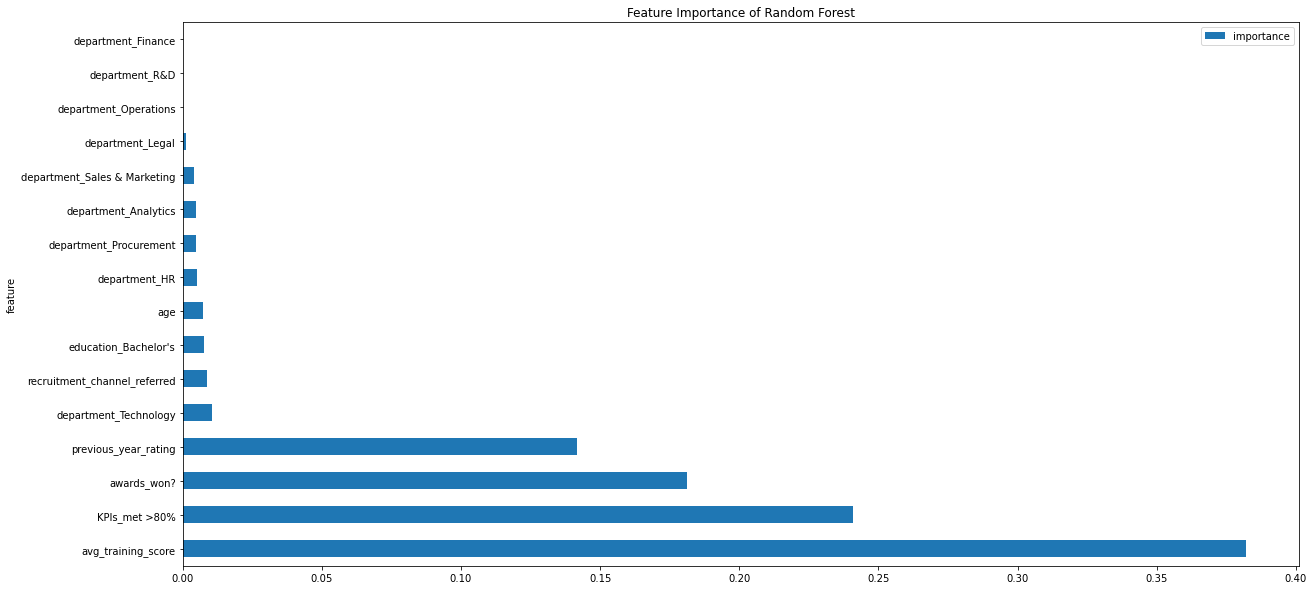

In [42]:
top_10 = stats.sort_values('importance', ascending=False).head(16)
top_10.plot(y='importance', x='feature', kind='barh')
plt.title('Feature Importance of Random Forest');

###### Feature importance for random forest with max depth 3

In [43]:
feature_importances = models['random_forest_3'][-1].feature_importances_
#features = best[-1]
features = X_train.columns
stats1 = pd.DataFrame({'feature':features, 'importance':feature_importances})
stats1.head(16)

,feature,importance
0,age,0.003499
1,previous_year_rating,0.094445
2,KPIs_met >80%,0.268519
3,awards_won?,0.176870
4,avg_training_score,0.426961
5,education_Bachelor's,0.002661
6,recruitment_channel_referred,0.001486
7,department_Analytics,0.008315
8,department_Finance,0.000308
9,department_HR,0.000521


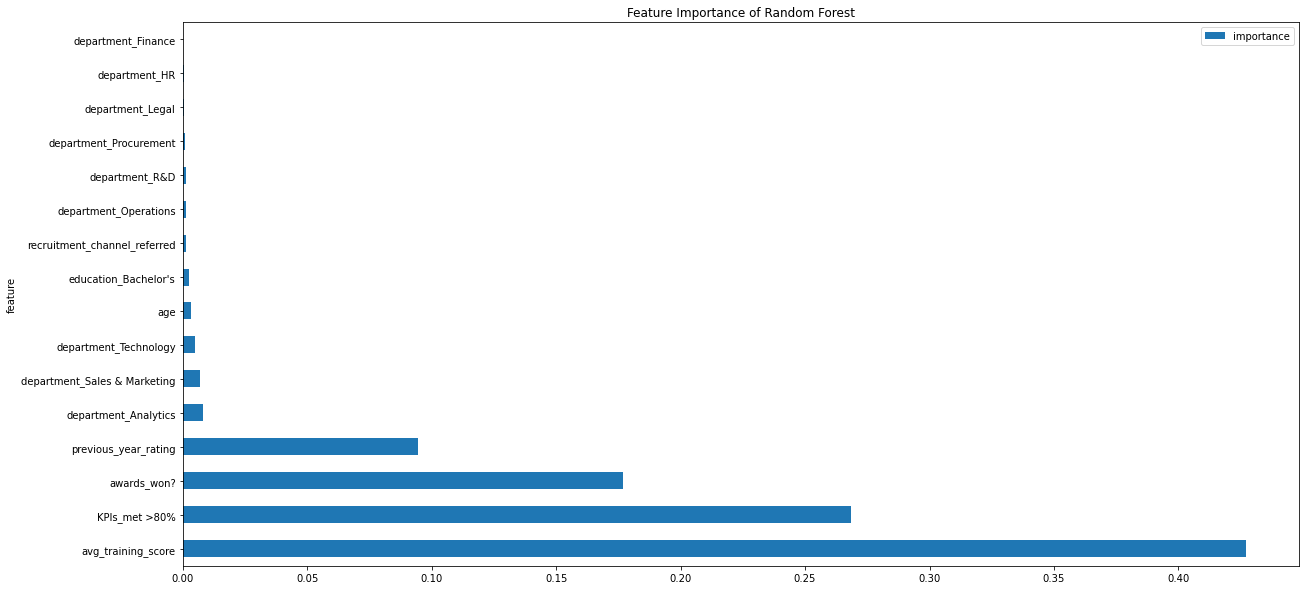

In [44]:
top_10 = stats1.sort_values('importance', ascending=False).head(16)
top_10.plot(y='importance', x='feature', kind='barh')
plt.title('Feature Importance of Random Forest');

##### Feature importance for random forest with max depth 4

In [45]:
feature_importances = models['random_forest_4'][-1].feature_importances_
#features = best[-1]
features = X_train.columns
stats2 = pd.DataFrame({'feature':features, 'importance':feature_importances})
stats2.head(16)

,feature,importance
0,age,0.004018
1,previous_year_rating,0.089198
2,KPIs_met >80%,0.221801
3,awards_won?,0.143280
4,avg_training_score,0.487143
5,education_Bachelor's,0.002345
6,recruitment_channel_referred,0.001674
7,department_Analytics,0.014595
8,department_Finance,0.000416
9,department_HR,0.001801


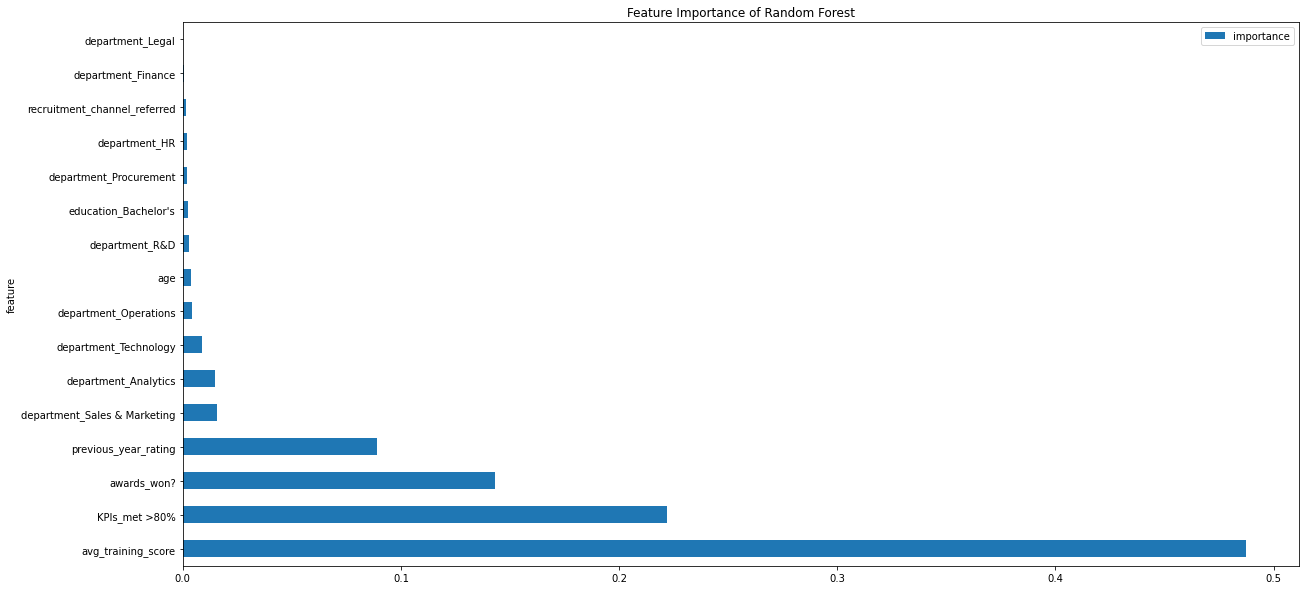

In [46]:
top_10 = stats2.sort_values('importance', ascending=False).head(16)
top_10.plot(y='importance', x='feature', kind='barh')
plt.title('Feature Importance of Random Forest');

## 	Hyperparameters

######  As written in question 8 we used the best performing algorithm you found and we changed the hyper parameters of the algorithm many time in order to get  the best improvment of  the test performance, then  we showed a comparison in the performance on a plot.

In [47]:
n_estimators_values = [70, 100, 120, 140, 180, 200, 220, 250, 280, 300, 325, 350 , 375, 400, 425, 450, 500]
results = pd.DataFrame()
lst = []
best_score = 0
for n in tqdm(n_estimators_values):
    for i in range(2,8):
        y_train_pred,y_test_pred, f1 ,precision, recall,t_auc, clf = foo3(XGBClassifier(n_estimators=n,
                                                                                        max_depth=i,
                                                                                        scale_pos_weight=2,
                                                                                       verbosity=0),
                                                                          X_train, X_test, y_train, y_test)
        lst.append([f1,i,n,precision,recall,t_auc])
        if f1>best_score:
            best_score = f1
            best_hyper = y_train_pred,y_test_pred, f1 ,precision, recall,t_auc, clf

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [01:13<00:00,  4.30s/it]


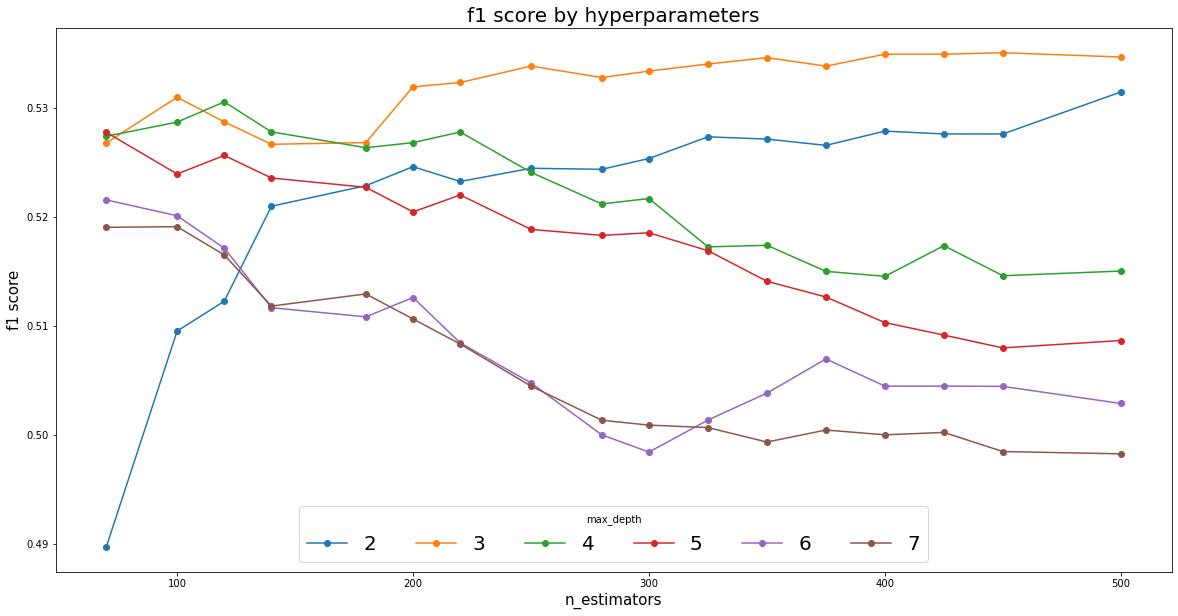

In [48]:
df = pd.DataFrame(lst,columns=['f1','max_depth','n_estimators','precision','recall','t_auc'])
groups = df.groupby('max_depth')
for name, group in groups:
    plt.plot(group["n_estimators"], group["f1"], marker="o", linestyle="solid", label=name)
plt.legend(loc='lower center',prop={'size': 20},ncol=6,title='max_depth')
plt.title('f1 score by hyperparameters',size=20)
plt.xlabel('n_estimators',size=15)
plt.ylabel('f1 score',size=15)
plt.show()

##### Here we presented the f1 score and the hyper parameters of the best model

In [49]:
temp = df[df.index==df.f1.idxmax()]

In [50]:
temp

,f1,max_depth,n_estimators,precision,recall,t_auc
91,0.535088,3,450,0.824324,0.396104,0.694167


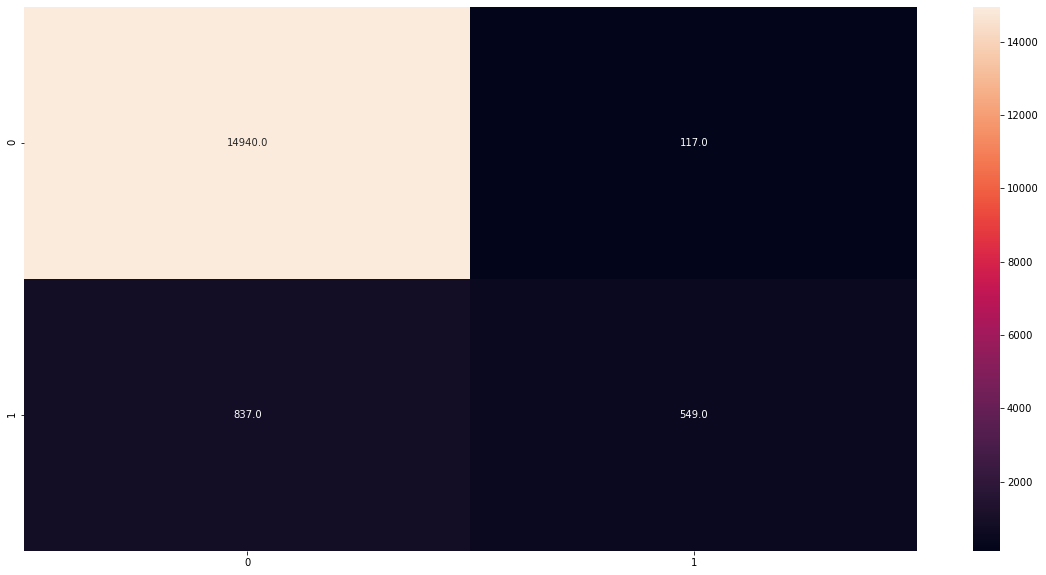

In [51]:
confu(y_test,best_hyper[1])

### Different  sample sizes

###### As written in question 9 we employed the best model on different train and test sizes and we presented the results on a plot 

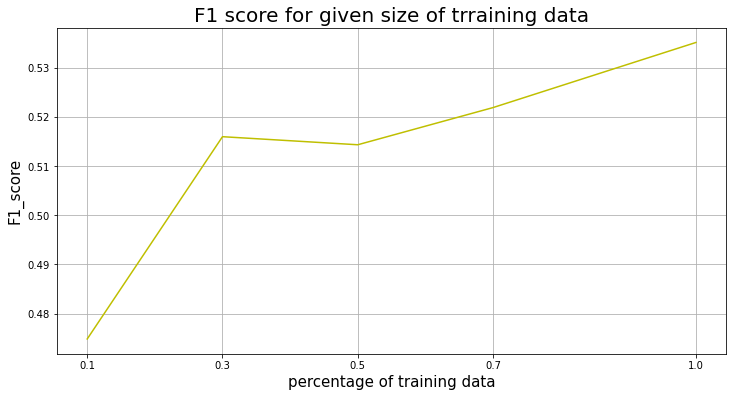

In [52]:
ratios = np.array([0.1,0.3,0.5,0.7,1])
best_f1 = 0
accuracy = []
for ratio in ratios:
    #X_train, X_test, y_train, y_test = foo2(best[-1],y,ratio)
    X_train_ratio = X_train[:int(ratio*len(X_train))]
    y_train_ratio = y_train[:int(ratio*len(y_train))]
    y_train_pred,y_test_pred, f1 ,precision, recall,t_auc, clf  = foo3(XGBClassifier(n_estimators=temp['n_estimators'].values[0],
                                                                                     max_depth=temp['max_depth'].values[0],
                                                                                    scale_pos_weight=2,
                                                                                    verbosity=0),
                                                                       X_train_ratio, X_test, y_train_ratio, y_test)
 #   if f1>best_f1:
  #      bestybest = (y_test,y_test_pred), f1 ,precision, recall,t_auc
   #     best_f1 = f1
    accuracy.append(f1)
    

plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(ratios, accuracy, 'y')
plt.xticks(ratios)
plt.xlabel('percentage of training data', size = 15)
plt.ylabel('F1_score' , size = 15)
plt.title('F1 score for given size of trraining data', fontsize=20)
plt.show()

###### Yes we recommend to collect more data because we can see that as long as we are increasing the train data the performane of the model is getting better

In [54]:
'''
def mirror(seq):
    return np.array([cm[1][::-1] ,cm[0][::-1]])

cm = confusion_matrix(y_test,y_test_pred)
sns.heatmap(mirror(cm),annot=True)
precision = cm[0,0]/(cm[0,0]+cm[1,0])
recall = cm[0,0]/(cm[0,0]+cm[0,1])
f1 = 2*((precision*recall)/(precision+recall))
print(f"precision: {precision}\nrecall: {recall}\nf1: {f1}")
'''

'\ndef mirror(seq):\n    return np.array([cm[1][::-1] ,cm[0][::-1]])\n\ncm = confusion_matrix(y_test,y_test_pred)\nsns.heatmap(mirror(cm),annot=True)\nprecision = cm[0,0]/(cm[0,0]+cm[1,0])\nrecall = cm[0,0]/(cm[0,0]+cm[0,1])\nf1 = 2*((precision*recall)/(precision+recall))\nprint(f"precision: {precision}\nrecall: {recall}\nf1: {f1}")\n'